https://zhuanlan.zhihu.com/p/416569496

# 1 模型设计
本次考虑一个单层的承压含水层。

假设一200m×100m的长方形，划分为20×10格，步长均为10m的网格区域。

网格区域左右两侧和下侧第10~16格为定水头边界（见下图波浪线区域），分别为1m3/d，4m3/d和3m3/d。

区内共有四口井，其坐标分别为：A(4, 4)，B(5, 10)，C(1, 15)，D(8, 18)，其中，

B为抽水井，抽水速率为1400m3/d；ACD为补水井，补水速率分别为500m3/d，300m3/d和600m3/d。

区内垂直渗透系数均为10m/d，水平渗透系数分为四个区域

相比`tutorial-3`，修改了水井、区域水平渗透系数

# 2 建模
mf2005的建模顺序比较清晰，可归纳为：

创建模型；
设置模型的网格信息并建立离散化单元；
建立边界等信息；
建立含水层特性；
建立井信息；
输出控制；
写入mf2005，并运行模型。

## 2.1 创建模型

导入模块

In [1]:
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
%config InlineBackend.figure_format = 'svg'
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
config = {
    'font.family':'Times New Roman',
    'font.size': 15,
    'font.serif': ['SimSun'],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset':'stix',
    'savefig.dpi':300,}
plt.rcParams.update(config)

创建mf2005模型需调用 `flopy.modflow.Modflow`

In [2]:
modelname = "tut3a1_model" # 模型名称
mf = flopy.modflow.Modflow(modelname, exe_name="mf2005", namefile_ext = 'nam', model_ws = './tut3_model', version = 'mf2005')

## 2.2 网格信息和离散化单元

In [3]:
# 网格信息
Lx = 200.0                   # x的长度
Ly = 100.0                   # y的长度
ztop = 0.0                   # z的顶部高程
zbot = -10.0                 # z的底部高程
nlay = 1                     # 含水层数量
nrow = 10                    # y网格数
ncol = 20                    # x网格数
delr = Ly / nrow             # y步长
delc = Lx / ncol             # x步长
delv = (ztop - zbot) / nlay  # z步长
botm = np.linspace(ztop, zbot, nlay + 1)
# botm可在z方向将研究区划分为若干个含水层/隔水层。在本例子中仅有一层，因此仅为 nlay+1
# botm和top可以是单个浮点数，也可以是二维数组，用于描述每一含水层顶底板的高程变化

> 注意：botm可在z方向将研究区划分为若干个含水层/隔水层。在本例子中仅有一层，因此仅为 nlay+1。botm和top可以是单个浮点数，也可以是二维数组，用于描述每一含水层顶底板的高程变化。

完成上述信息后即可进行离散化单元，主要调用 `flopy.modflow.ModflowDis`：

In [4]:
# Discretization Input File (DIS) 离散化输入文件
# 参数分别是 模型名，层数，x格数，y格数，x，y密度，顶部高程，底部高程
dis = flopy.modflow.ModflowDis(
    mf, 
    nlay, nrow, ncol,
    delr = delr, delc = delc, 
    top = ztop, 
    botm = botm[1:] # botm[0]为top的值，因此从1开始计数
)

本节步骤对应生成了输出文件中的 `*.dis` 文件。

## 2.3 定义边界和水头
MODFLOW中的边界条件ibound共有三种状态，即<0，0，>0。

* ibound<0，表明是定水头的单元，通常用-1表示；
* ibound=0，表明是隔水单元；
* ibound>0，表明是活动单元，通常用1表示。

初始状态下所有单元 ibound 默认为 1，因此定义定水头边界，需将 ibound 改为 -1。

根据第1节中信息可知，网格区域左右两侧和下侧第10~16格为定水头边界，其值分别为1m3/d，4m3/d 和 3m3/d。

建立边界单元信息和初始水头值：

In [5]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
ibound[:, -1, 10:17] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 1.0
strt[:, :, -1] = 4.0
strt[:, -1, 10:17] = 3.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

> 注意：无论是 ibound，strt，以及渗透系数等单元信息，均为 [z, x, y] 的三维数组形式。

本节步骤对应生成了输出文件中的 `*.bas` 文件。

## 2.4 设置含水层特性
本节主要是设置含水层的渗透系数和确定含水层类型，需调用 `flopy.modflow.ModflowLpf`

`flopy.modflow.ModflowLpf` 中的 laytyp 用于设置含水层的类型。

 * laytyp=0，表明是承压含水层
 * laytyp>0，表明是潜水含水层
 * laytyp<0，表明可转换

本节步骤对应生成了输出文件中的 `*.lpf` 文件

In [6]:
hk = np.ones((nlay, nrow, ncol), dtype=np.float32)
hk[:, :, :4] = 1.0
hk[:, :2, 4:10] = 2.0
hk[:, 2:7, 4:10] = 10.0
hk[:, 7:, 4:10] = 2.0
hk[:, :, 10:] = 8.0
lpf = flopy.modflow.ModflowLpf(mf, hk = hk, vka = 10.0, ipakcb=53)
# laytyp (int or array of ints (nlay)) 默认为0，表明为承压含水层
# 0 confined >0 convertible <0 convertible unless the THICKSTRT option is in effect. (default is 0).

## 2.5 设置井
根据第1节中条件，调用 `flopy.modflow.ModflowWel`，设置井的信息如下：

In [7]:
spd = {
    0: [
        [0, 4, 4, 500], 
        [0, 5, 10, -1400], 
        [0, 1, 15, 300], 
        [0, 8, 18, 600],
    ],
}
wel = flopy.modflow.ModflowWel(mf, stress_period_data = spd)

井的信息利用字典进行储存，一个键值对代表了该应力周期内井的位置和抽/补水效率。

字典的键表示为不同的应力周期。由于本例中地下水是稳定流，因此只有一个键值对。

字典的值由两个列表包含而成，每一个子列表代表一口井，列表值的顺序是[z, x, y, 抽/补水]。

本节步骤对应生成了输出文件中的 `*.wel` 文件。

## 2.6 输出设置
spd 依旧是一个字典，其键用元组展示，代表了应力周期和时间步长。

在同一个应力周期内，模型的边界等条件不会发生改变。时间步长则反映为在一个应力周期内划分模型在时间尺度上的间隔。应力周期和时间步长均在事先进行设置。

本例为稳定流，因此仅需设为 (0, 0)，不同应力周期和时间步长的设置将在后续非稳定流中另外交代。

`flopy.modflow.ModflowPcg` 用于对模型求解。

本节步骤对应生成了输出文件中的 `*.oc`、`*.pcg` 文件。

In [8]:
spd = {(0, 0): ["print head", "print budget", "save head", "save budget"]}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
pcg = flopy.modflow.ModflowPcg(mf)

## 2.7 运行模型

In [9]:
mf.write_input()
success, buff = mf.run_model()
if not success:
    raise Exception("MODFLOW did not terminate normally.")

FloPy is using the following executable to run the model: ..\..\..\..\..\modflow\MF2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: tut3a1_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/07/04 11:25:52

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/07/04 11:25:52
 Elapsed run time:  0.002 Seconds

  Normal termination of simulation


# 3 可视化
本次模拟共生成以下文件：
```
my_model.bas
my_model.cbc
my_model.dis
my_model.hds
my_model.list
my_model.lpf
my_model.nam
my_model.oc
my_model.pcg
my_model.wel
```
若绘制渗流场，需提取 `my_model.hds` 文件。

渗流场展示为：

c:\Users\Ken\Desktop\modflow-pg\.venv\lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


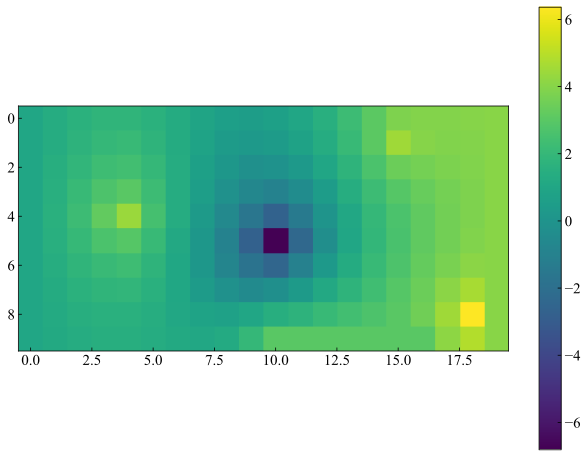

In [10]:
# 提取水头数据
hds = bf.HeadFile(f'./tut3_model/{modelname}.hds')
head = hds.get_data(totim=1.0)
df = pd.DataFrame(head[0])
plt.figure(figsize=(11,8))
plt.imshow(df)
plt.colorbar()

In [ ]:
for row in head[0]:
    for entry in row:
        print(f'{entry:.2f}', end=', ')
    print()

1.00, 1.32, 1.61, 1.80, 1.83, 1.62, 1.27, 0.90, 0.62, 0.54, 0.67, 0.98, 1.51, 2.21, 3.02, 3.80, 3.90, 3.91, 3.95, 4.00, 
1.00, 1.37, 1.70, 1.96, 2.05, 1.76, 1.30, 0.81, 0.41, 0.25, 0.42, 0.76, 1.33, 2.09, 3.05, 4.50, 3.97, 3.89, 3.93, 4.00, 
1.00, 1.44, 1.87, 2.26, 2.40, 1.95, 1.33, 0.70, 0.15, -0.18, -0.11, 0.31, 0.98, 1.77, 2.61, 3.40, 3.61, 3.74, 3.87, 4.00, 
1.00, 1.52, 2.07, 2.69, 2.97, 2.20, 1.36, 0.57, -0.15, -0.73, -0.97, -0.38, 0.49, 1.39, 2.21, 2.90, 3.32, 3.60, 3.82, 4.00, 
1.00, 1.56, 2.22, 3.22, 4.38, 2.50, 1.35, 0.37, -0.60, -1.65, -2.67, -1.36, -0.02, 1.08, 1.96, 2.65, 3.16, 3.53, 3.80, 4.00, 
1.00, 1.50, 2.03, 2.62, 2.89, 2.08, 1.16, 0.18, -0.98, -2.70, -6.81, -2.38, -0.28, 0.99, 1.90, 2.60, 3.14, 3.57, 3.86, 4.00, 
1.00, 1.40, 1.78, 2.13, 2.25, 1.76, 1.03, 0.16, -0.81, -1.82, -2.47, -1.05, 0.26, 1.27, 2.05, 2.69, 3.24, 3.73, 4.05, 4.00, 
1.00, 1.30, 1.58, 1.79, 1.86, 1.54, 1.03, 0.43, -0.15, -0.50, -0.25, 0.38, 1.12, 1.78, 2.34, 2.86, 3.41, 4.07, 4.62, 4.00, 
1.00, 1.2